In [0]:
# mounts Google Drive to the Colab VM
from google.colab import drive, files
drive.mount('/content/drive')

# project github foldername
FOLDERNAME = '/content/drive/My Drive/CS231N/Project/RainfallNowcasting/RadarData/'

# load python files from foldername
import sys
sys.path.append(FOLDERNAME)

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import datetime
import data_preprocessing
import pandas as pd
import plot_data

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import colors
%matplotlib inline
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 3

!pip install netcdf4

     |████████████████████████████████| 4.1MB 8.0MB/s 
     |████████████████████████████████| 327kB 56.0MB/s 


In [0]:
# !!! ONLY LOAD DATA THAT ARE FOLLOWING EACH OTHER IN TIME !!!

zone = "NW"    # NW
years = [2016]    # 2016, 2017 or 2018
months = [2]
part_months = [2, 3] # Choice between 1,2,3, as we said earlier each month is divided in 3 parts
#min and max indexes when the dataset is loaded in memory
ind_min = None # or values such as ind_min < ind_max and they must be within the range of the number of data that you are trying to download
ind_max = None
new_size = [64,64] # None if you want to keep initial size
directory = '/content/drive/My Drive/CS231N/Project/MeteoNet_dataset/meteonet_dataset/'
input_timeframes = 10 # Choose how many timeframes you want for the input
output_timeframes = 5 # Choose how many timeframes you want for the output
overlapping_data = 0 # Choose if you want the data to overlap (= 1) or not (= 0)
motion_content_data = 0 # Choose if your input data are for MCNet (= 1) or ConvLSTM (= 0)
normalization_min = 0 # Choose between -1 and 0, the max is always 1
rain_or_reflectivity = 1 # 0 if working on rainfall data, 1 if working on reflectivity data
percentage_test = 0.1  # Choose percentage of data to put in test data
if rain_or_reflectivity == 0:
  threshold_value = 80 # Value above which values are considered to be one
else:
  threshold_value = 60 

# Additional features
lsm_bool = 0  # Include Land/sea mask (= 1) or not (= 0)
lsm_position = 0  # Add the lsm mask as another channel in each input (= 1) or keep it separate (= 0)
elevation_bool = 0  # Include Land/sea mask (= 1) or not (= 0)
elevation_position = 0  # Add the lsm mask as another channel in each input (= 1) or keep it separate (= 0)
model = 'arpege' # 'arome' or 'arpege'
temperature_bool = 1
temperature_position = 1
dew_point_temperature_bool = 1
dew_point_temperature_position = 1
humidity_bool = 1
humidity_position = 1
wind_speed_bool = 1
wind_speed_position = 1
wind_direction_bool = 1
wind_direction_position = 1
wind_components_bool = 1
wind_components_position = 1
pressure_bool = 1
pressure_position = 1
precipitation_bool = 1
precipitation_position = 1
weather_model_bool = {'temperature': temperature_bool, 'dew point temperature' : dew_point_temperature_bool,
                 'humidity': humidity_bool, 'wind speed': wind_speed_bool, 'wind directions': wind_direction_bool,
                 'wind components': wind_components_bool, 'pressure': pressure_bool,
                 'precipitation': precipitation_bool}
weather_model_position = {'temperature': temperature_position, 'dew point temperature' : dew_point_temperature_position,
                 'humidity': humidity_position, 'wind speed': wind_speed_position, 'wind directions': wind_direction_position,
                 'wind components': wind_components_position, 'pressure': pressure_position,
                 'precipitation': precipitation_position}

In [0]:
[lat, lon] = data_preprocessing.get_coords(directory, zone)

In [0]:
if motion_content_data == 0:
  X, y, y_mask, X_dates = data_preprocessing.data_preprocess(directory, years, months, part_months, zone, new_size, ind_min, ind_max, input_timeframes, output_timeframes, overlapping_data, motion_content_data, normalization_min, rain_or_reflectivity, threshold_value)
  print(X.shape)
  print(y.shape)
  print(y_mask.shape)
  print(X_dates.shape)
  N, T, H, W, C = X.shape
else:
  X_motion, X_content, y, y_mask, X_motion_dates, X_content_dates = data_preprocessing.data_preprocess(directory, years, months, part_months, zone, new_size, ind_min, ind_max, input_timeframes, output_timeframes, overlapping_data, motion_content_data, normalization_min, rain_or_reflectivity, threshold_value)
  print(X_motion.shape)
  print(X_content.shape)
  print(y.shape)
  print(y_mask.shape)
  print(X_motion_dates.shape)
  print(X_content_dates.shape)
  N, T, H, W, C = X_motion.shape

Year: 2016 Month: 2 Part of the month: 2, Done !
Year: 2016 Month: 2 Part of the month: 3, Done !
(364, 10, 64, 64, 1)
(364, 5, 64, 64, 1)
(364, 5, 64, 64, 1)
(364, 10)


In [0]:
if lsm_bool == 1:
  lsm_mask = data_preprocessing.get_lsm_relief_mask(directory+'Masks/Masks/', zone, [H,W], "lsm")
  if lsm_position == 1:
    if motion_content_data == 0:
      X = data_preprocessing.add_new_channel(X, lsm_mask)
      print(X.shape)
      N, T, H, W, C = X.shape
    else:
      X_motion = data_preprocessing.add_new_channel(X_motion, lsm_mask)
      X_content = data_preprocessing.add_new_channel(X_content, lsm_mask)
      print(X_motion.shape)
      print(X_content.shape)
      N, T, H, W, C = X_motion.shape

In [0]:
if elevation_bool == 1:
  elevation_mask = data_preprocessing.get_lsm_relief_mask(directory+'Masks/Masks/', zone, [H,W], "p3008")
  if elevation_position == 1:
    if motion_content_data == 0:
      X = data_preprocessing.add_new_channel(X, elevation_mask)
      print(X.shape)
      N, T, H, W, C = X.shape
    else:
      X_motion = data_preprocessing.add_new_channel(X_motion, elevation_mask)
      X_content = data_preprocessing.add_new_channel(X_content, elevation_mask)
      print(X_motion.shape)
      print(X_content.shape)
      N, T, H, W, C = X_motion.shape

In [0]:
if motion_content_data == 0:
  model_data_dict = data_preprocessing.get_model_data(directory, zone, model, weather_model_bool, X_dates, [H,W])
  X = data_preprocessing.add_model_channel(X, model_data_dict, weather_model_position, motion_content_data)
  print(X.shape)
else:
  model_data_dict = data_preprocessing.get_model_data(directory, zone, model, weather_model_bool, X_motion_dates, [H,W])
  X_motion, X_content = data_preprocessing.add_model_channel(X_motion, model_data_dict, weather_model_position, motion_content_data, X_content)
  print(X_motion.shape)
  print(X_content.shape)

(364, 10, 64, 64, 10)


In [0]:
if motion_content_data == 0:
  X, y, X_test, y_test = data_preprocessing.split_train_test(percentage_test, motion_content_data, X, y)
  print(X.shape)
  print(y.shape)
  print(X_test.shape)
  print(y_test.shape)
  N, T, H, W, C = X.shape
else:
  X_motion, X_content, y, X_motion_test, X_content_test, y_test =  data_preprocessing.split_train_test(percentage_test, motion_content_data, X_motion, y, X_content)
  print(X_motion.shape)
  print(X_content.shape)
  print(y.shape)
  print(X_motion_test.shape)
  print(X_content_test.shape)
  print(y_test.shape)
  N, T, H, W, C = X_motion.shape

(296, 10, 64, 64, 10)
(296, 5, 64, 64, 1)
(32, 10, 64, 64, 10)
(32, 5, 64, 64, 1)


In [0]:
# Custom metrics
def ssim(y_gt, y_pred, max_val=1.):
  return tf.image.ssim(y_gt, y_pred, max_val)
def psnr(y_gt, y_pred, max_val=1.):
  return tf.image.psnr(y_gt, y_pred, max_val)
def cor(y_gt, y_pred):
  return tfp.stats.correlation(y_gt, y_pred, sample_axis=None, event_axis=None)

In [0]:
#
# Parameters
#
loss = 'logcosh'
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
activ = 'selu'
init = 'lecun_normal'
nk = 128
ks = 5
lks = 3
#
Ninput = 10
Noutput = 5
#
Nsample = 100
bs = 2
ep = 1

In [0]:
# Model Architecture
def model_init():
  inputs = tf.keras.Input(shape=[None, H, W, C])
  # Encoder
  CL1, cl1_h, cl1_c, _, _ = tf.keras.layers.Bidirectional(tf.keras.layers.ConvLSTM2D(nk, ks, padding='same',
                                                          activation=activ, kernel_initializer=init,
                                                          return_sequences=True, return_state=True))(inputs)
  CL2, cl2_h, cl2_c = tf.keras.layers.ConvLSTM2D(nk, ks, padding='same',
                                                 activation=activ, kernel_initializer=init,
                                                 return_state=True)(CL1)
  # Decoder 1
  CL3 = tf.keras.layers.ConvLSTM2D(nk, ks, padding='same',
                                   activation=activ, kernel_initializer=init,
                                   return_sequences=True)(tf.zeros([Noutput, H, W, nk])[None, :, :, :, :],
                                                          initial_state=[cl1_h, cl1_c])
  CL4 = tf.keras.layers.ConvLSTM2D(nk, ks, padding='same',
                                   activation=activ, kernel_initializer=init,
                                   return_sequences=True)(CL3, initial_state=[cl2_h, cl2_c])
  # Deepen
  conv1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(nk, ks, padding='same',
                                                                 activation=activ, kernel_initializer=init))(CL4)
  conv2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(nk, ks, padding='same',
                                                                 activation=activ, kernel_initializer=init))(conv1)
  conv3 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(nk, ks, padding='same',
                                                                 activation=activ, kernel_initializer=init))(conv2)
  conv4 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(nk, ks, padding='same',
                                                                 activation=activ, kernel_initializer=init))(conv3)
  conv5 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(nk, ks, padding='same',
                                                                 activation=activ, kernel_initializer=init))(conv4)
  conv6 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(nk, ks, padding='same',
                                                                 activation=activ, kernel_initializer=init))(conv5)
  conv7 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(nk, ks, padding='same',
                                                                 activation=activ, kernel_initializer=init))(conv6)
  conv8 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(nk, ks, padding='same',
                                                                 activation=activ, kernel_initializer=init))(conv7)
  conv9 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(nk, ks, padding='same',
                                                                 activation=activ, kernel_initializer=init))(conv8)
  # Decoder 2
  CL5 = tf.keras.layers.ConvLSTM2D(nk, ks, padding='same',
                                   activation=activ, kernel_initializer=init,
                                   return_sequences=True)(conv9, initial_state=[cl1_h, cl1_c])
  CL6 = tf.keras.layers.ConvLSTM2D(nk, ks, padding='same',
                                   activation=activ, kernel_initializer=init,
                                   return_sequences=True)(CL5, initial_state=[cl2_h, cl2_c])
  # Prediction
  preds = tf.keras.layers.Conv3D(1, lks, padding='same',
                                 bias_initializer=tf.keras.initializers.Constant(value=-np.log(99)),
                                 activation='sigmoid')(CL6)
  return tf.keras.Model(inputs=inputs, outputs=preds)

In [0]:
# Initialize model
model = model_init()

# Build optimizer
if normalization_min == 0:
  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['acc', ssim, psnr, cor,
                        tf.keras.metrics.Precision(name='prec'),
                        tf.keras.metrics.Recall(name='recall')])
else:
  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['acc'])

# Fit the model
history = model.fit(X, y, 
                    batch_size=bs, 
                    epochs=ep,
                    validation_split=0.1)

# Get results on test set
results = model.evaluate(X_test, y_test, batch_size=bs, return_dict=True)

16/16 [==============================] - 8s 524ms/step - loss: 0.0649 - acc: 0.7648 - ssim: 0.6413 - psnr: 8.2364 - cor: -0.0545 - prec: 0.4815 - recall: 0.0108


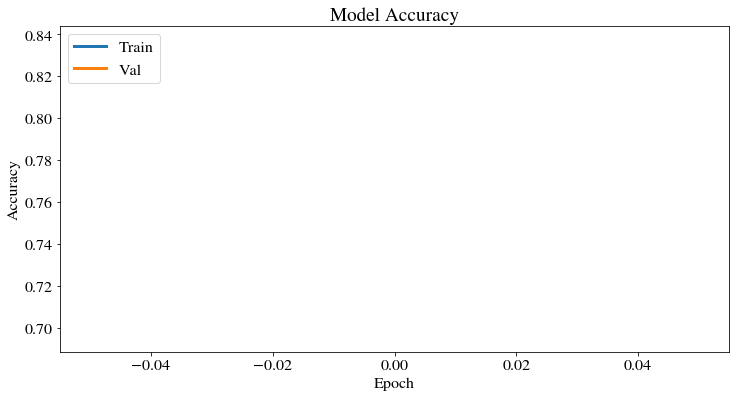

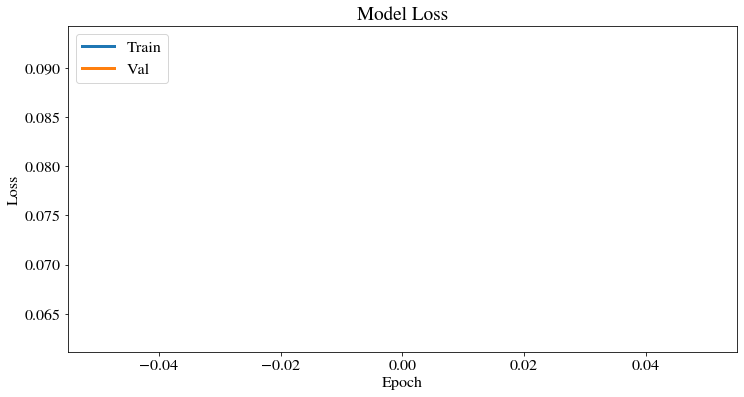

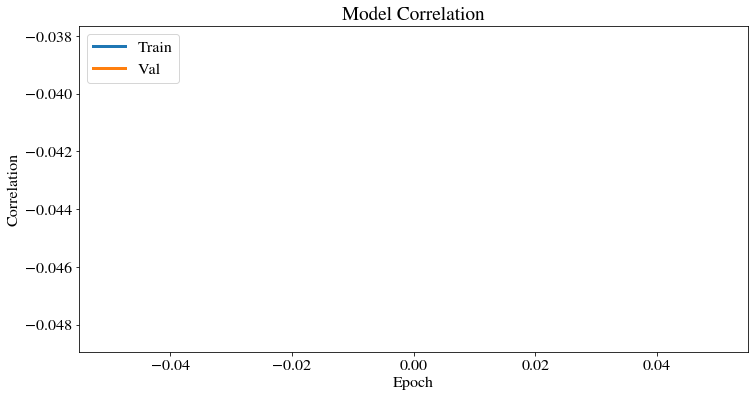

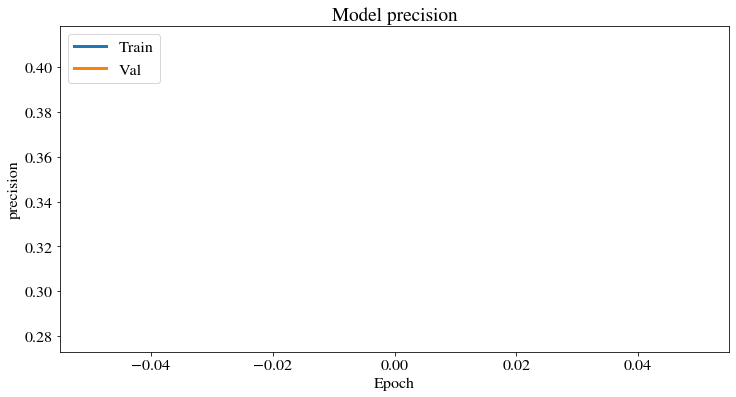

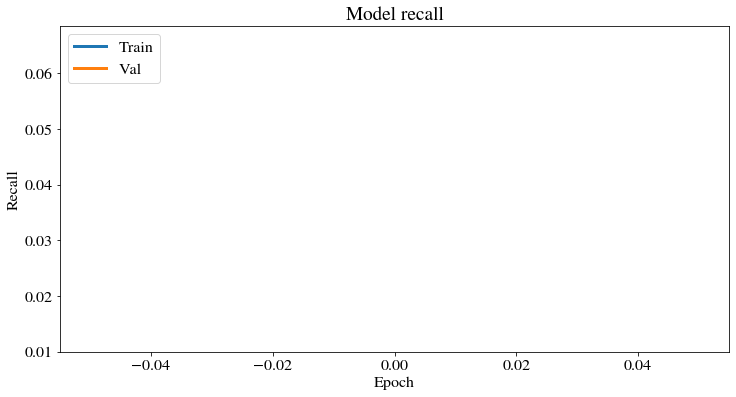

In [0]:
# Plot of loss, accuracy, cor, prec and recall
foldername = "/content/drive/My Drive/Results_project/test/"
plot_data.plot_history(history, normalization_min, save=False, foldername=foldername)

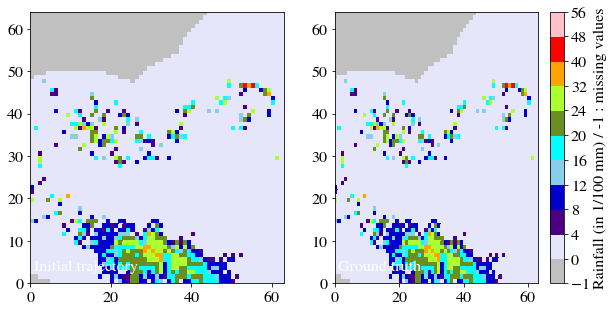

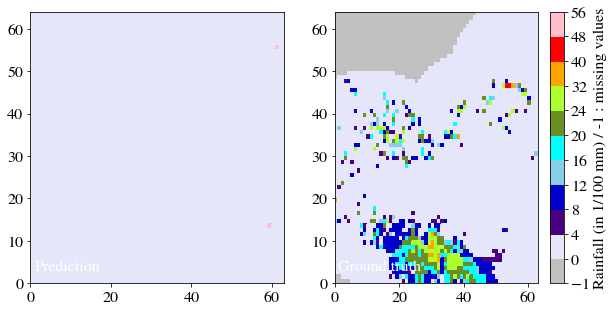

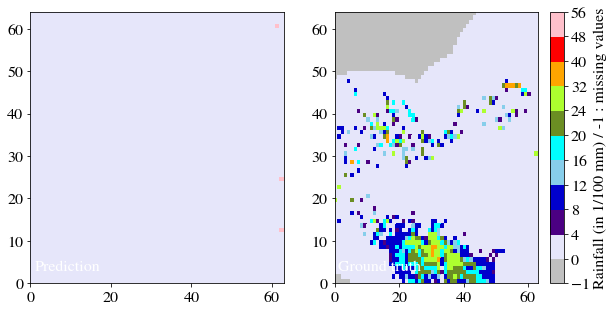

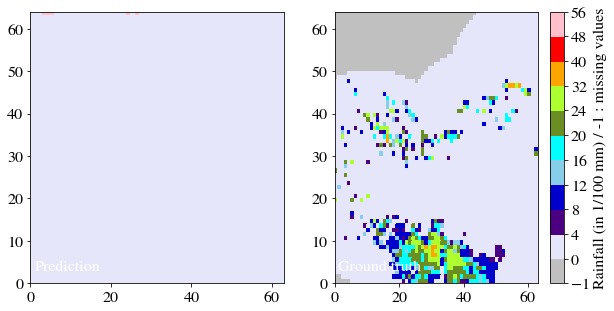

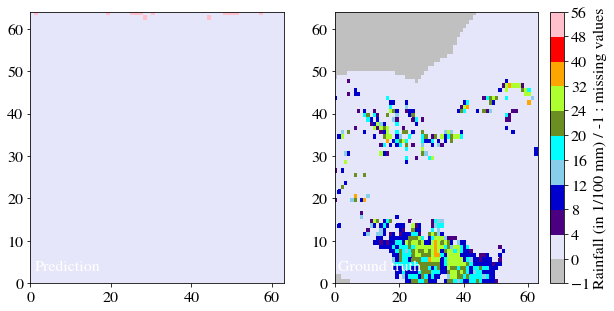

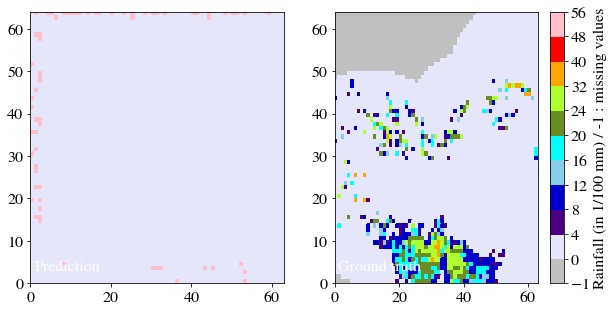

In [0]:
# Plot Train
if motion_content_data == 0:
  itest = 1
  track = X[itest, :, :, :, :]
  last_frame = X[itest, -1, :, :, :]
  track_y = y[itest, :, :, :, :]
  track = np.concatenate((last_frame[None, None,:,:,0:1], model.predict(track[None,:,:,:,:])), axis=1)
  true_track = np.concatenate((last_frame[None, :, :, 0:1], track_y), axis=0)
  plot_data.plot_track(true_track, track, rain_or_reflectivity, normalization_min, 
                       threshold_value, new_size, output_timeframes,
                       save=False, foldername='')
else:
  itest = 1
  track_content = X_content[itest]
  track_motion = X_motion[itest]
  track_y = y[itest, :, :, :, :]
  track = np.concatenate((track_content[None, None,:,:,0:1], model.predict([track_motion[None, :, :, :, :], track_content[None, :, :, :]])), axis=1)
  true_track = np.concatenate((track_content[None, :, :, 0:1], track_y), axis=0)
  plot_data.plot_track(true_track, track, rain_or_reflectivity, normalization_min, 
                       threshold_value, new_size, output_timeframes,
                       save=False, foldername='')
  

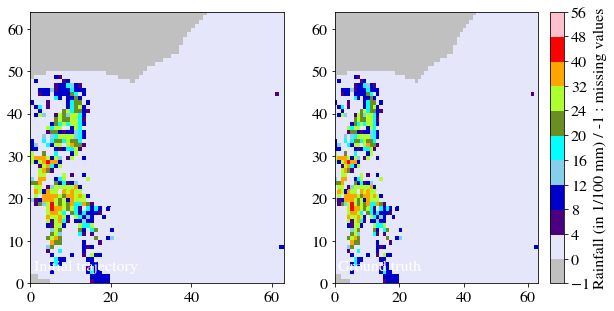

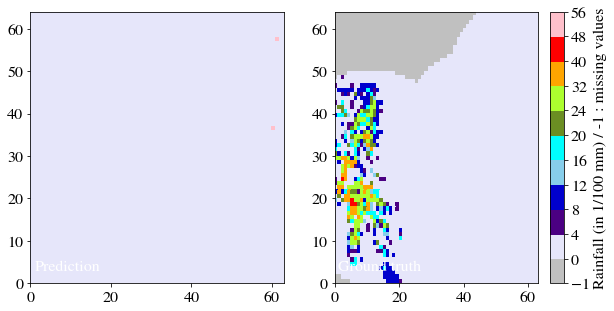

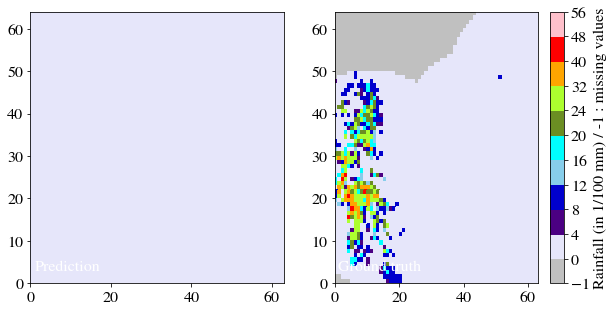

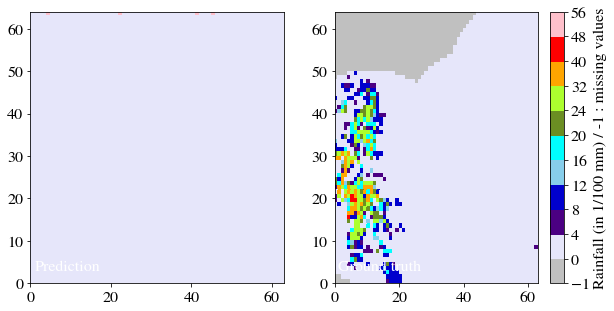

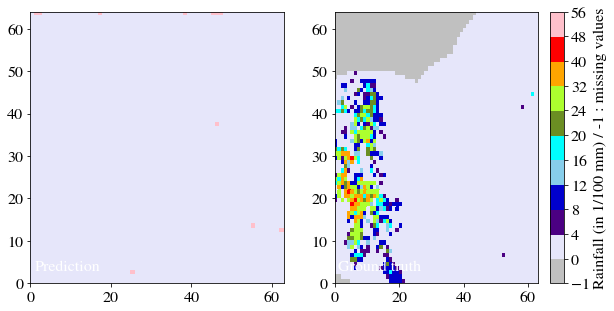

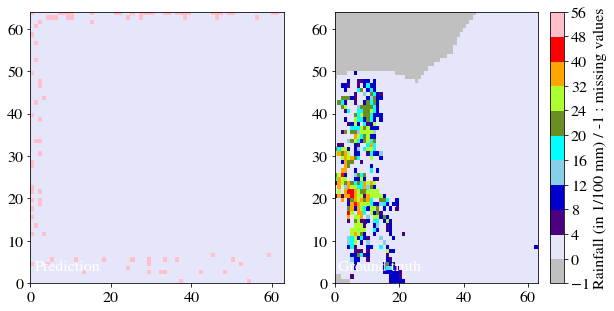

In [0]:
# Select a random observation, initial trajectory and predicted trajectory
# Plot Test
if motion_content_data == 0:
  itest = 1
  track = X_test[itest, :, :, :, :]
  last_frame = X_test[itest, -1, :, :, :]
  track_y = y_test[itest, :, :, :, :]
  track = np.concatenate((last_frame[None, None,:,:,0:1], model.predict(track[None,:,:,:,:])), axis=1)
  true_track = np.concatenate((last_frame[None, :, :, 0:1], track_y), axis=0)
  plot_data.plot_track(true_track, track, rain_or_reflectivity, normalization_min, 
                       threshold_value, new_size, output_timeframes,
                       save=False, foldername='')
else:
  itest = 1
  track_content = X_content_test[itest]
  track_motion = X_motion_test[itest]
  track_y = y_test[itest, :, :, :, :]
  track = np.concatenate((track_content[None, None,:,:,0:1], model.predict([track_motion[None, :, :, :, :], track_content[None, :, :, :]])), axis=1)
  true_track = np.concatenate((track_content[None, :, :, 0:1], track_y), axis=0)
  plot_data.plot_track(true_track, track, rain_or_reflectivity, normalization_min, 
                       threshold_value, new_size, output_timeframes,
                       save=False, foldername='')